In [2]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
class Disk:

    def __init__(self, radius, thickness, density=8.92e3, resistivity=1.73e-8, N_rings=50, N_sectors=90):
        self.radius = radius
        self.thickness = thickness
        self.density = density
        self.resistivity = resistivity
        self.N_rings = N_rings
        self.N_sectors = N_sectors
        self.dr = self.radius/self.N_rings
        self.dphi = 2*np.pi/self.N_sectors
        
    def radii(self):
        return np.linspace(self.dr, self.radius, self.N_rings) - self.dr/2
    
    def angles(self):
        return np.linspace(0, 2*np.pi*self.dphi, self.N_sectors)

    def sectors(self):
        return (self.radii()*self.dr/2)**2 * np.pi/self.N_sectors
        
    def sectorrings(self):
        self.areas_sectorrings = np.diff(self.sectors())
        return np.insert(self.areas_sectorrings, 0, self.sectors()[0])
    
    def mass(self):
        return self.density * self.radius*self.radius*np.pi * self.thickness
    
    def resistance_rings(self):
        return self.resistivity * 2*np.pi * self.radii()/(self.dr*self.thickness)


In [4]:
def flux(disk, pos, B):
    rs = disk.radii()
    phis = disk.angles()
    As = disk.sectors()
    posx, posy = pos

    flux = 0
    for r, A in zip(rs, As):
        x = posx + r*np.cos(phis)
        y = posy + r*np.sin(phis)
        flux += (B(x, y) * A).sum()
    
    return flux

In [5]:
def B(x, y):
    B0 = 10
    return (x>0) * B0 * x

In [6]:
def Forces(rvecs, Is, pos, B):

    N_rings, N_sectors = rvecs.shape[0:2]

    dls = np.diff(rvecs, axis=1)
    dls = np.append(dls, np.reshape(rvecs[:, 0]-rvecs[:, -1], (N_rings, 1, 3)), axis=1)

    x = (rvecs + dls/2 + pos)[:, :, 0]
    y = (rvecs + dls/2 + pos)[:, :, 1]
    
    Bvec = np.concatenate((np.zeros((2*N_rings, N_sectors)), B(x, y)))
    Bvec = np.reshape(Bvec, (3, N_rings, N_sectors))
    Bvec = np.moveaxis(Bvec, 0, 2)

    Fs = (np.reshape(Is, (N_rings, 1, 1)) * np.cross(dls, Bvec)).sum(axis=1)

    return Fs

In [7]:
disk = Disk(0.1, 1e-3)

# disk.N_rings = 100
# disk.N_sectors = 180

m = disk.mass() # mass of copper plate
Rs = disk.resistance_rings() # resistance of rings

x0 = -0.11 # initial position of plate
v0 = 0.2 # initial velocity in x direction

# define time and position arrays
N_steps = 50 # number of steps for simulation
tmax = 2 # time range for simulation
dt = tmax/N_steps
t = np.linspace(0, tmax, N_steps)

# define quantities for calculation of force
x = np.zeros(N_steps) # define empty array for positions
vx = np.zeros(N_steps) # define empty array for velocities
Fx = np.zeros((N_steps, 3)) # define empty array for forces

x[0] = x0 # initial position
vx[0] = v0 # initial velocity
flux0 = np.array([flux(disk, (x0, 0), B) for i in range(disk.N_rings)])

# define vectors for segments
rxs = [r * np.cos(disk.angles()) for r in disk.radii()]
rys = [r * np.sin(disk.angles()) for r in disk.radii()]
rzs = np.zeros((disk.N_rings, disk.N_sectors))

r_vecs = np.moveaxis(np.array([rxs, rys, rzs]), 0, 2)

# loop to calculate positions
for i in tqdm(range(N_steps-1)):
    fluxi = np.array([flux(disk, (x[i], 0), B) for n in range(disk.N_rings)])

    Eis = -(fluxi-flux0)/dt # induced emf (Faraday's law)
    flux0 = fluxi
    Is = Eis/Rs # calculate currents through rings

    Fs = Forces(r_vecs, Is, (x[i], 0, 0), B)
    Fx[i] = Fs.sum(axis=0)
    
    ax = Fx[i, 0]/m # acceleration in x direction
    
    vx[i+1] = vx[i] + ax*dt
    x[i+1] = x[i] + vx[i+1]*dt

100%|██████████| 49/49 [00:01<00:00, 25.63it/s]


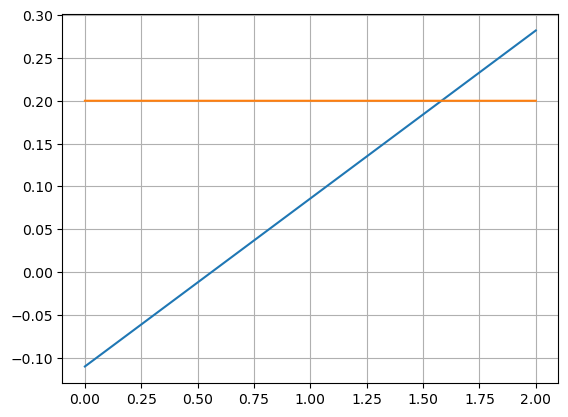

In [8]:
plt.plot(t, x)
plt.plot(t, vx)
plt.grid()

In [245]:
x[-1]

-0.04968721738073672

In [203]:
x[-1]

-0.0357524256972745

In [40]:
r_vecs

array([[[1.00000000e-03, 0.00000000e+00, 0.00000000e+00],
        [9.99996997e-04, 2.45055109e-06, 0.00000000e+00],
        [9.99987990e-04, 4.90108747e-06, 0.00000000e+00],
        ...,
        [9.07396947e-04, 4.20274650e-04, 0.00000000e+00],
        [9.06364318e-04, 4.22497010e-04, 0.00000000e+00],
        [9.05326246e-04, 4.24716834e-04, 0.00000000e+00]],

       [[1.98989899e-03, 0.00000000e+00, 0.00000000e+00],
        [1.98989302e-03, 4.87634914e-06, 0.00000000e+00],
        [1.98987509e-03, 9.75266900e-06, 0.00000000e+00],
        ...,
        [1.80562827e-03, 8.36304101e-04, 0.00000000e+00],
        [1.80357344e-03, 8.40726374e-04, 0.00000000e+00],
        [1.80150778e-03, 8.45143598e-04, 0.00000000e+00]],

       [[2.97979798e-03, 0.00000000e+00, 0.00000000e+00],
        [2.97978903e-03, 7.30214719e-06, 0.00000000e+00],
        [2.97976219e-03, 1.46042505e-05, 0.00000000e+00],
        ...,
        [2.70385959e-03, 1.25233355e-03, 0.00000000e+00],
        [2.70078256e-03, 1.25